<img src="logo.jpg" width="700" />

# Email Structural analysis using a Neural Network (NN) approach for TA2 layer of PANACEA project

The purpose of this code is to present an approach for __detecting the central parts of an email__. The main idea, is to create a NN that can be used for detecting __greetings, content and signature elements__ associated to the textual content of a message.

__Code main elements:__

1. All the code was implemented in Python 3.7.1 https://www.python.org/
2. The dataset used is a labeled subset of the well known Enron dataset and Apache mailing list. More information can be found here: https://github.com/HPI-Information-Systems/Quagga/blob/master/Datasets/DATA.md 
3. The  Python packages required to run the programs are the following:
    * Jupyter notebook (Python interactive prompt) http://jupyter.org/index.html
    * Matplotlib (visualization) https://matplotlib.org/
    * Numpy (mathematical functions) http://www.numpy.org/
    * Scipy (mathematical functions) https://www.scipy.org/
    * NLTK (Natural Language Processing) https://www.nltk.org/
    * sklearn (Machine Learning) http://scikit-learn.org/stable/
    * Gensim https://radimrehurek.com/gensim/
    
__For more information see:__

1. https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
2. https://github.com/HPI-Information-Systems/Quagga

## Predefined tool


Check an existing package called "Quagga" for detecting the parts of an email: https://github.com/HPI-Information-Systems/QuaggaLib

The package classify each text line into one of five types: __Header, Body, Body/Intro, Body/Outro, Body/Signature.__


In [1]:
from Quagga import (Quagga, 
            EmailDirectoryReader, 
            ListReaderRawEmailTexts, 
            ListReaderExtractedBodies, 
            TempQuaggaReader, 
            ModelBuilder)
from Quagga.Utils.BlockParser.BlockParser import BlockParser

quagga = Quagga(ListReaderExtractedBodies(''), 
                output_dir='', # optional, saves to directory if set
                model_builder=ModelBuilder(with_crf=True, zones=5, trainset='enron'), # optional
                block_parser=BlockParser()) # optional
email_body_text= ("Hi,\nI am trying to use the ConnectedComponent algorithm of GraphFrames but by default it"+
                 "needs a checkpoint directory. As I am running my spark cluster with S3 as the DFS and do not"+
                 " have access to HDFS file system I tried using a s3 directory as checkpoint directory but I run"+
                 " into below exception:\nRegards Sumit Chawla\n Susan Priest\nClasses of '77 and '81")
classified_lines = quagga.predict(email_body_text)
print(classified_lines)

ModuleNotFoundError: No module named 'Quagga'

## Create our own classification model

1\. Obtain the current Jupyter notebook path

In [2]:
#Operating system functions for interacting with folders and files
import os
noteBookPath= os.getcwd()
os.chdir(noteBookPath)
print (noteBookPath)

D:\School\ILS\StructuralAnalaysis


2\. Extract representative samples (all elements labeled as Body, Body/Intro, Body/Outro, Body/Signature) from Quagga training and test datasets.

In [3]:
#Encoding functions for opening files in the correct format
import codecs
import errno
#Operating system functions for interacting with folders and files
import os
from os import listdir
import sys
import traceback
#Mathematical functions to handle vectors
import numpy as np
#object-serializing functions
import pickle
#Calendar functions for timestamp
import datetime
import time
#Encoding functions to handle Json files
import json
#Text maipulation functions (eliminate certain words for instance)
import re

#Check if the notebook path is already loaded
try:  
    noteBookPath
except NameError:
    print ("NotebookPath variable dont exist, applying default one")
    noteBookPath= os.getcwd()
    pass
    
#Check if dataset path exist
datasetFolder="dataset"
try:
    datasetsPath=os.path.join(noteBookPath,datasetFolder) 
    if not os.path.isdir(datasetsPath): raise Exception("'Dataset' folder dont exist")
    else: 
        print ("Directory: '"+ datasetFolder+"' exists")
        pass
except SystemExit as e:
    print(e)

#Create experiments folder if not exists
dirName="experiments"
try:
    os.mkdir(os.path.join(noteBookPath,dirName) )
    print ("Directory: '"+dirName+"' Created") 
except OSError as e:
    if e.errno == errno.EEXIST:
        print ("Directory: '"+ dirName+"' exists")
        pass
    else:
        raise 
except:
    print ("Unexpected error")
    pass  

#Check if the experiments folder path exist
try:  
    experimentsPath
except NameError:
    print ("datasetPath variable dont exist, applying default one")
    experimentsPath=os.path.join(noteBookPath,dirName)
    pass

#Python Script
try:
    
    document = "structuralAnaysisTraining.txt"
    filePath = os.path.join(experimentsPath,document)
    
    document2 = "structuralAnaysisTest.txt"
    filePath2 = os.path.join(experimentsPath,document2)
    
    contentType=["Body", "Body/Intro", "Body/Outro", "Body/Signature"]
    
    if not (os.path.isfile(filePath)):

        print("Create trainig document")
        trainingSamples=[]
        
        textStatistics={"Body":[], "Body/Intro":[], "Body/Outro":[], "Body/Signature":[]}
        
        dataSetsTraining=["enronTrain","apacheTrain"]
        for dataSetName in dataSetsTraining:
            datasetPath=os.path.join(datasetsPath,dataSetName)
            emailSamples = [f for f in listdir(datasetPath) if f.endswith(".ann")]
            
            for emailName in emailSamples:
                emailPath=os.path.join(datasetPath,emailName)
                with codecs.open(emailPath,"r",'utf8') as file:
                    count=0
                    data = json.load(file)
                    for elements in data["denotations"]:
                        if elements["type"] in contentType:
                            text=elements["text"].lower()
                            text=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',"", text)
                            text=re.sub(r"\S*@\S*\s?","", text)
                            text=re.sub(r"[^A-Za-z0-9\n]+"," ", text)
                            text=text.split("\n")
                            text=[(i, x) for i, x in enumerate(text, 1)]
                            temp=text[-1][0]
                            text=[x for x in text if len(x[1])>1]
                            
                            #Statistics about the structure of the email 
                            for x in text:
                                if elements["type"]=="Body": 
                                    textStatistics["Body"].append((count+x[0],len(x[1])))
                                elif elements["type"]=="Body/Intro": 
                                    textStatistics["Body/Intro"].append((count+x[0],len(x[1])))
                                elif elements["type"]=="Body/Outro": 
                                    textStatistics["Body/Outro"].append((count+x[0],len(x[1])))
                                elif elements["type"]=="Body/Signature": 
                                    textStatistics["Body/Signature"].append((count+x[0],len(x[1])))    
                            
                            #Write training samples to a file
                            text=[emailName+" @@@ "+elements["type"]+" @@@ "+str(count+x[0]) +" @@@ "+str(len(x[1]))
                                  +" @@@ "+x[1] for x in text]
                            count=count+temp
                            trainingSamples.extend(text)
        
        print("Average 'Body' length: "+str(np.average([x[1] for x in textStatistics["Body"]])))
        print("Average 'Body' position: "+str(np.average([x[0] for x in textStatistics["Body"]])))
        print("Average 'Body/Intro' length: "+str(np.average([x[1] for x in textStatistics["Body/Intro"]])))
        print("Average 'Body/Intro' position: "+str(np.average([x[0] for x in textStatistics["Body/Intro"]])))
        print("Average 'Body/Outro' length: "+str(np.average([x[1] for x in textStatistics["Body/Outro"]])))
        print("Average 'Body/Outro' position: "+str(np.average([x[0] for x in textStatistics["Body/Outro"]])))
        print("Average 'Body/Signature' length: "+str(np.average([x[1] for x in textStatistics["Body/Signature"]])))
        print("Average 'Body/Signature' position: "+str(np.average([x[0] for x in textStatistics["Body/Signature"]])))
        
        with codecs.open(filePath, "w",'utf8') as file:    
            [file.write(x+"\n") for x in trainingSamples]
    
    else: print ("Training document already exist")
        
    if not (os.path.isfile(filePath2)): 
        
        print("Create test document")
        testSamples=[]
        
        textStatistics={"Body":[], "Body/Intro":[], "Body/Outro":[], "Body/Signature":[]}
        
        dataSetsTest=["enronTest","apacheTest"]
        for dataSetName in dataSetsTest:
            datasetPath=os.path.join(datasetsPath,dataSetName)
            emailSamples = [f for f in listdir(datasetPath) if f.endswith(".ann")]
            for emailName in emailSamples:
                emailPath=os.path.join(datasetPath,emailName)
                with codecs.open(emailPath,"r",'utf8') as file:
                    count=0
                    data = json.load(file)
                    for elements in data["denotations"]:
                        if elements["type"] in contentType:
                            text=elements["text"].lower()
                            text=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',"", text)
                            text=re.sub(r"\S*@\S*\s?","", text)
                            text=re.sub(r"[^A-Za-z0-9\n]+"," ", text)
                            text=text.split("\n")
                            text=[(i, x) for i, x in enumerate(text, 1)]
                            temp=text[-1][0]
                            text=[x for x in text if len(x[1])>1]
                            text=[emailName+" @@@ "+elements["type"]+" @@@ "+str(count+x[0]) +" @@@ "+str(len(x[1]))
                                  +" @@@ "+x[1] for x in text]
                            count=count+temp
                            testSamples.extend(text)
    
        with codecs.open(filePath2, "w",'utf8') as file:    
            [file.write(x+"\n") for x in testSamples]    
    
    else: print ("Test document already exist")
    
except IOError as e:
    print ("Could not read file")
    print(traceback.format_exc())
    print(e)
except Exception as e:
    print ("Unexpected error")
    print(traceback.format_exc())
    print(e)     

Directory: 'dataset' exists
Directory: 'experiments' exists
datasetPath variable dont exist, applying default one
Training document already exist
Test document already exist


In [40]:
from gensim.models.keyedvectors import KeyedVectors
model2 = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

C:\Users\Shark\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


3\. Extract character ngrams from project emails (JPL, Enron, APWG, etc.) in order to create distinct embedding models. These models will be used for generating training and test vectors associated to Quagga samples.

In [35]:
#Word embeddings functions to create word vectors
import gensim 
#Encoding functions for opening files in the correct format
import codecs
import errno
#Operating system functions for interacting with folders and files
import os
from os import listdir
import sys
import traceback
#Mathematical functions to handle vectors
import numpy as np
#object-serializing functions
import pickle
#Calendar functions for timestamp
import datetime
import time
#Text maipulation functions (eliminate certain words for instance)
import re

friendFoeTrainingTexts=[]
#Check if the notebook path is already loaded
try:  
    noteBookPath
except NameError:
    print ("NotebookPath variable dont exist, applying default one")
    noteBookPath= os.getcwd()
    pass


#Check if dataset path exist
datasetFolder="dataset"
try:
    datasetsPath=os.path.join(noteBookPath,datasetFolder) 
    if not os.path.isdir(datasetsPath): raise Exception("'Dataset' folder dont exist")
    else: 
        print ("Directory: '"+ datasetFolder+"' exists")
        pass
except SystemExit as e:
    print(e)

#Create experiments folder if not exists
dirName="experiments"
try:
    os.mkdir(os.path.join(noteBookPath,dirName) )
    print ("Directory: '"+dirName+"' Created") 
except OSError as e:
    if e.errno == errno.EEXIST:
        print ("Directory: '"+ dirName+"' exists")
        pass
    else:
        raise 
except:
    print ("Unexpected error")
    pass  

#Check if the experiments folder path exist
try:  
    experimentsPath
except NameError:
    print ("datasetPath variable dont exist, applying default one")
    experimentsPath=os.path.join(noteBookPath,dirName)
    pass

#Python Script
try:
    
    #Character ngram size
    characterNgram=1
    #Character embedding size vectors
    featureNumbers=[600]
    
    document = "friendFoeTraining.txt"
    filePath = os.path.join(experimentsPath,document)
    
    document2 = "friendFoeTrainingCharacterNgramSize-"+str(characterNgram)+".txt"
    filePath2 = os.path.join(experimentsPath,document2)
    
    if (os.path.isfile(filePath)):
        
         if not (os.path.isfile(filePath2)): 
            
            print("Extracting character ngrams of size: "+str(characterNgram))
            friendFoeTraining=[]
            with codecs.open(filePath,"r",'ISO-8859-1') as file:
                for line in file:
                    elements=line.split(" @@@ ")
                    #Preprocess the text samples
                    elements[1]=elements[1].replace("#", "")
                       #Eliminate URls
                    elements[1]=re.sub(r"http\S+","", elements[1])
                       #Eliminate usernames (which don't give any additional information for this analysis)
                    elements[1]=re.sub(r"@[^\s]+","",elements[1])
                    #text=text.replace(" ", "")
                    #Sseparate words in character ngrams for creating the embedding model
                    #text=" ".join([text[i:i+characterNgram] for i in range(len(text)-characterNgram+1)])
                    friendFoeTraining.append(elements[0] + " @@@ " + elements[1])
                    friendFoeTrainingTexts.append(elements[1])
                    
                
            with codecs.open(filePath2, "w",'ISO-8859-1') as file:    
                #[file.write(x[0]+" @@@ "+x[1]+"\n") for x in friendFoeTraining]
                [file.write(text) for text in friendFoeTraining]
                
                
                
            
            print(friendFoeTrainingTexts[0])
            for number in featureNumbers:
            
                document3 = "ngram-"+str(characterNgram)+"-EmbeddingModelSize-"+str(number)
                filePath3 = os.path.join(experimentsPath,document3)
                
                if not (os.path.isfile(filePath3)): 
                    
                    print("Creating word embedding model of size: "+str(number))
                    #Traing wordEmbedding model
                    model = gensim.models.Word2Vec(friendFoeTrainingTexts,size=number,window=10,min_count=2,workers=10)
                    model.train(friendFoeTrainingTexts, total_examples=len(friendFoeTrainingTexts), epochs=10)
                    #Serialize word-embedding object
                    with open(filePath3, "wb") as file:
                        pickle.dump(model, file)
                else: print ("Model: '"+document3+"' already exist")        
                        
         else: 
            
            print ("Document: '"+document2+"' already exist")
            
            with codecs.open(filePath2,"r",'ISO-8859-1') as file:
                friendFoeTrainingTexts=[(line.split(" @@@ ")[1]).split(" ") for line in file]
            
            for number in featureNumbers:
            
                document3 = "ngram-"+str(characterNgram)+"-EmbeddingModelSize-"+str(number)
                filePath3 = os.path.join(experimentsPath,document3)
                
                
                if not (os.path.isfile(filePath3)): 
                    
                    print("Creating word embedding model of size: "+str(number))
                    #Traing wordEmbedding model
                    model = gensim.models.Word2Vec(friendFoeTrainingTexts,size=number,window=10,min_count=2,workers=10)
                    model.train(friendFoeTrainingTexts, total_examples=len(friendFoeTrainingTexts), epochs=10)
                    #Serialize word-embedding object
                    with open(filePath3, "wb") as file:
                        pickle.dump(model, file)
                else: print ("Model: '"+document3+"' already exist") 
                 
    else: print ("Friend/foe training document dont exist")
         
except IOError as e:
    print ("Could not read file")
    print(traceback.format_exc())
    print(e)
except Exception as e:
    print ("Unexpected error")
    print(traceback.format_exc())
    print(e)      

Directory: 'dataset' exists
Directory: 'experiments' exists
Document: 'friendFoeTrainingCharacterNgramSize-1.txt' already exist
Creating word embedding model of size: 600


4\. Create training and test vectors for structural dataset considering the previously created embedding models.

In [47]:
#Word embeddings functions to create word vectors
import gensim 
#Encoding functions for opening files in the correct format
import codecs
import errno
#Operating system functions for interacting with folders and files
import os
from os import listdir
import sys
import traceback
#Mathematical functions to handle vectors
import numpy as np
#object-serializing functions
import pickle
#Calendar functions for timestamp
import datetime
import time
#Text maipulation functions (eliminate certain words for instance)
import re

#Check if the notebook path is already loaded
try:  
    noteBookPath
except NameError:
    print ("NotebookPath variable dont exist, applying default one")
    noteBookPath= os.getcwd()
    pass


#Check if dataset path exist
datasetFolder="dataset"
try:
    datasetsPath=os.path.join(noteBookPath,datasetFolder) 
    if not os.path.isdir(datasetsPath): raise Exception("'Dataset' folder dont exist")
    else: 
        print ("Directory: '"+ datasetFolder+"' exists")
        pass
except SystemExit as e:
    print(e)

#Create experiments folder if not exists
dirName="experiments"
try:
    os.mkdir(os.path.join(noteBookPath,dirName) )
    print ("Directory: '"+dirName+"' Created") 
except OSError as e:
    if e.errno == errno.EEXIST:
        print ("Directory: '"+ dirName+"' exists")
        pass
    else:
        raise 
except:
    print ("Unexpected error")
    pass  

#Check if the experiments folder path exist
try:  
    experimentsPath
except NameError:
    print ("datasetPath variable dont exist, applying default one")
    experimentsPath=os.path.join(noteBookPath,dirName)
    pass

#Python Script
try:
    
    document = "structuralAnaysisTraining.txt"
    filePath = os.path.join(experimentsPath,document)

    document2 = "structuralAnaysisTest.txt"
    filePath2 = os.path.join(experimentsPath,document2)
    
    #Character ngram size
    characterNgram=1
    #Character embedding size vectors
    featureNumbers=[300]
    
    #Training vectors creation (if needed)
    if os.path.isfile(filePath):
        
        trainingTexts=[]
        labels=[]
        trainingLabels=[]
        with codecs.open(filePath, "r", "utf8") as file: 
            for line in file:
                try:
                    elements=line.split(" @@@ ")
                    labels.append(elements[1])
                    #text=elements[4].rstrip()
                    trainingTexts.append((elements[4].rstrip()).split(" "))
                except IndexError: pass
                
                
        for label in labels:
            if label=="Body":         trainingLabels.append(["1", "0", "0", "0"])
            elif label=="Body/Intro": trainingLabels.append(["0", "1", "0", "0"])
            elif label=="Body/Outro": trainingLabels.append(["0", "0", "1", "0"]) 
            else:                     trainingLabels.append(["0", "0", "0", "1"])
        
        
        #Create character embeddings for training emails
        for number in featureNumbers:
            
            print("Create training vectors of size: "+str(number))
            
            document3 = "Ngram-"+str(characterNgram)+"-EmbeddingModelSize-"+str(number)
            filePath3 = os.path.join(experimentsPath,document3)
            
            document4 = "ngram-"+str(characterNgram)+"TrainingVectorsSize-"+str(number)+".txt"
            filePath4 = os.path.join(experimentsPath,document4)
        
            if (os.path.isfile(filePath3)) and not os.path.isfile(filePath4):
                
                with open(filePath3, "rb") as file: 
                    model= pickle.load(file,encoding="bytes")
                
                #Create training vectors   
                trainingVectors=[]
                for text in trainingTexts:
                    wordVectors=[]
                    for word in text:
                        try:
                            if word in model:
                                wordVectors.append(model[word])
                            elif word in model2:
                                wordVectors.append(model2[word])
                        except:
                            pass
                    if len(wordVectors)>=1:    
                          wordVectors=np.array(wordVectors)    
                          trainingVectors.append((wordVectors.mean(axis=0)).tolist())
                    else: trainingVectors.append([0 for x in range(number)])
                        
                #Save train vectors in a text file
                with codecs.open(filePath4, "w", 'ISO-8859-1') as file:   
                    for vector,label in zip(trainingVectors,trainingLabels):
                        file.write((",".join(label))+","+(",".join([str(x) for x in vector]))+"\n")
                            
            else: print ("Character embedding model dont exist or training vectors already created")
                    
    else: print ("Training document: "+document+" dont exist")
        
        
    #Test vectors creation (if needed)
    if os.path.isfile(filePath2):
                       
        testTexts=[]
        labels=[]
        testLabels=[]
        with codecs.open(filePath2, "r", "utf8") as file: 
            for line in file:
                try:
                    elements=line.split(" @@@ ")
                    labels.append(elements[1])
                    #text=elements[1].rstrip()
                    testTexts.append((elements[4].rstrip()).split(" "))
                except IndexError: pass
                 
        for label in labels:
            if label=="Body":         testLabels.append(["1", "0", "0", "0"])
            elif label=="Body/Intro": testLabels.append(["0", "1", "0", "0"])
            elif label=="Body/Outro": testLabels.append(["0", "0", "1", "0"]) 
            else:                     testLabels.append(["0", "0", "0", "1"]) 
                             
        #Create character embeddings for test emails
        for number in featureNumbers:
            
            print("Create test vectors of size: "+str(number))
            
            document3 = "Ngram-"+str(characterNgram)+"-EmbeddingModelSize-"+str(number)
            filePath3 = os.path.join(experimentsPath,document3)

            document5 = "ngram-"+str(characterNgram)+"TestVectorsSize-"+str(number)+".txt"
            filePath5 = os.path.join(experimentsPath,document5)
        
            if (os.path.isfile(filePath3)) and not os.path.isfile(filePath5):
                
                with open(filePath3, "rb") as file: 
                    model= pickle.load(file,encoding="bytes")
                    
                #Create test vectors   
                testVectors=[]
                for text in testTexts:
                    testVector=[]
                    for word in text:
                        try:
                            if word in model:
                                testVector.append(model[word])
                            elif word in model2:
                                testVector.append(model2[word])
                        except:
                            pass
                    if len(testVector)>=1:    
                          testVector=np.array(testVector)    
                          testVectors.append((testVector.mean(axis=0)).tolist())
                    else: testVectors.append([0 for x in range(number)])
                        
                #Save test vectors in a text file
                with codecs.open(filePath5, "w", 'ISO-8859-1') as file:   
                    for vector,label in zip(testVectors,testLabels):
                        file.write((",".join(label))+","+(",".join([str(x) for x in vector]))+"\n")               
            
            else: print ("Character embedding model dont exist or test vectors already created")
                 
    else: print ("Test document: "+document2+" dont exist")      

except IOError as e:
    print ("Could not read file")
    print(traceback.format_exc())
    print(e)
except Exception as e:
    print ("Unexpected error")
    print(traceback.format_exc())
    print(e)  

Directory: 'dataset' exists
Directory: 'experiments' exists
Create training vectors of size: 300


C:\Users\Shark\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Shark\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Create test vectors of size: 300


C:\Users\Shark\Anaconda3\lib\site-packages\ipykernel_launcher.py:187: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Shark\Anaconda3\lib\site-packages\ipykernel_launcher.py:188: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


5\. Create and test a Neural Network (Back propagation approach) using the training and test vectors previously created.

In [49]:
import numpy as np
np.random.seed(1337) # for reproducibility
#Neural network functions for creating a prediction model
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
#Evaluation metrics for checking classification model performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#Operating system functions for interacting with folders and files
import codecs
import errno
import os
import sys
import traceback

#Check if the notebook path is already loaded
try:  
    noteBookPath
except NameError:
    print ("NotebookPath variable dont exist, applying default one")
    noteBookPath= os.getcwd()
    pass


#Check if dataset path exist
datasetFolder="dataset"
try:
    datasetsPath=os.path.join(noteBookPath,datasetFolder) 
    if not os.path.isdir(datasetsPath): raise Exception("'Dataset' folder dont exist")
    else: 
        print ("Directory: '"+ datasetFolder+"' exists")
        pass
except SystemExit as e:
    print(e)

#Create experiments folder if not exists
dirName="experiments"
try:
    os.mkdir(os.path.join(noteBookPath,dirName) )
    print ("Directory: '"+dirName+"' Created") 
except OSError as e:
    if e.errno == errno.EEXIST:
        print ("Directory: '"+ dirName+"' exists")
        pass
    else:
        raise 
except:
    print ("Unexpected error")
    pass  

#Check if the experiments folder path exist
try:  
    experimentsPath
except NameError:
    print ("datasetPath variable dont exist, applying default one")
    experimentsPath=os.path.join(noteBookPath,dirName)
    pass

#Python Script
try:
    
    #Parameters used for testing different Neural Network options
    hiddenLayers=[[50,40,30,20,10],[50,25,10],[50,50],[16,8],[32,16,8],[8,8,8],[8,8],[4,4]]
    batches=[x for x in range(20,110,5)]
    epochs=[x for x in range(3,10,1)] 
    #Labels used to predict the structure of emails
    structuralLabels=["Body", "Body/Intro", "Body/Outro", "Body/Signature"]
    #Mapping used for transforming values of the final NN layer to a specific structure category
    structureMapping={0:"Body", 1:"Body/Intro", 2:"Body/Outro", 3:"Body/Signature"}
    #Character ngram size
    characterNgram=1
    #Character embedding size vectors
    featureNumbers=[300]
    
    #Iterate over each previously created Word-embedding file
    for number in featureNumbers: 
        
        print("Character embeddings experiments using vectors of size: "+str(number))
        
        document = "ResultsNgramGooglewithOwn-"+str(characterNgram)+"-EmbeddingSize-"+str(number)+".txt"
        filePath = os.path.join(experimentsPath,document)
        
        if not (os.path.isfile(filePath)):
                
            #List that have all the experimental results associate to a character embedding size
            results=[]
        
            #Setting appropiate filepaths for experiments
            document2 = "ngram-"+str(characterNgram)+"TrainingVectorsSize-"+str(number)+".txt"
            filePath2 = os.path.join(experimentsPath,document2)
        
            document3 = "ngram-"+str(characterNgram)+"TestVectorsSize-"+str(number)+".txt"
            filePath3 = os.path.join(experimentsPath,document3)
            
            if os.path.isfile(filePath2) and os.path.isfile(filePath3):
                
                #Test different variations of a Neural Network using training and test data
                for layer in hiddenLayers:
                    
#                     #Read training vectors (Enron, JPL, etc.)
#                     with codecs.open(filePath2,"r", "ISO-8859-1") as file:
#                         vectors=[line.replace('\n','') for line in file]
                        
# #                     trainingVectors=[[float(feature) for feature in vector.split(",")[4:]] 
# #                                                 for vector in vectors]
#                     trainingLabels=[[int(feature) for feature in vector.split(",")[:4]] 
#                                                 for vector in vectors]
                    trainingVectors=np.array(trainingVectors)
                    trainingLabels=np.array(trainingLabels)
                    
                    #Read test vectors (Enron, JPL, etc.)
#                     with codecs.open(filePath3,"r", "ISO-8859-1") as file:
#                         vectors=[line.replace('\n','') for line in file]
#                     testVectors=[[float(feature) for feature in vector.split(",")[4:]] 
# #                                                 for vector in vectors]
#                     testLabels=[[int(feature) for feature in vector.split(",")[:4]] 
#                                                 for vector in vectors]
                    testVectors=np.array(testVectors) 
                    testLabels=np.array(testLabels)
                    
                    #Create the Neural Network architecture (Back-propagation approach)
                    classifier = Sequential()
                    #Hidden Layers
                    classifier.add(Dense(layer[0], activation='relu', kernel_initializer='random_normal', input_dim=number))
                    for element in layer[1:]:
                        classifier.add(Dense(element, activation='relu', kernel_initializer='random_normal'))
                        #Layer defined to avoid overfitting
                        classifier.add(Dropout(0.2))
                    #Output Layer
                    classifier.add(Dense(4, activation='softmax', kernel_initializer='random_normal'))
                    
                    #Compiling the Neural Network
                    classifier.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
                    
                    #Choose the number of epochs
                    for epoch in epochs:
                        #Choose the number of batches to handle
                        for batch in batches:

                            #Create the prediction model
                            classifier.fit(trainingVectors,trainingLabels, batch_size=batch, epochs=epoch,verbose=0)
                            #Predict the age for each sample in the test dataset
                            predictions = classifier.predict(testVectors)
                            #Get the neuron id (0, 1 ,2 or 3) with the highest probability and then extract the age label
                            predictedLabels=[structureMapping[np.argmax(x)] for x in predictions]
                            expectedLabels=[structureMapping[np.argmax(x)] for x in testLabels]
                            #Get model accuracy associated to each experiment
                            accuracy=accuracy_score(expectedLabels, predictedLabels)
                            """
                            Get F1-measure associated to each experiment
                            
                            F1 = 2 * (precision * recall) / (precision + recall)
                            
                            Calculate metrics for each label, and find their unweighted mean. This does not take 
                            label imbalance into account.
                            """
                            f1=f1_score(expectedLabels, predictedLabels, average='macro')  
                            #Get the confusion matrix associated to each experiment
                            confusionMatrix=confusion_matrix(expectedLabels, predictedLabels, labels=structuralLabels)
                            #Squish the matrix into a vector and then append all elements in a single string var
                            confusionMatrix=",".join([str(x) for x in confusionMatrix.flatten()])
                            #Print experimental results
                            numberLayers="-".join([str(x) for x in layer])
                            res= (str(number)+","+numberLayers+","+str(epoch)+","+str(batch)+
                                 ","+str(accuracy)+","+str(f1))
                            print(res)      
                            res=res+","+confusionMatrix    
                            results.append(res)

                #Write experimental results to a file            
                with codecs.open(filePath,"w", "ISO-8859-1") as file: 
                    [file.write(x+"\n") for x in results]
    
            else: print ("One of the following documents dont exist: "+document2+" or "+document3)    
            
        else: print ("The following document already exist: "+document)

except IOError as e:
    print ("Could not read file")
    print(traceback.format_exc())
    print(e)
except Exception as e:
    print ("Unexpected error")
    print(traceback.format_exc())
    print(e) 

Directory: 'dataset' exists
Directory: 'experiments' exists
Character embeddings experiments using vectors of size: 300
300,50-40-30-20-10,3,20,0.9423428491070173,0.8443389055898961
300,50-40-30-20-10,3,25,0.93362396287442,0.8200243920546941
300,50-40-30-20-10,3,30,0.9391084235691183,0.8098930963042977
300,50-40-30-20-10,3,35,0.9412178315286176,0.8062301051709501
300,50-40-30-20-10,3,40,0.9350302348474195,0.8212939565546891
300,50-40-30-20-10,3,45,0.9412178315286176,0.8273859609312932
300,50-40-30-20-10,3,50,0.9354521164393194,0.815714891083637
300,50-40-30-20-10,3,55,0.9422022219097174,0.8366257689774751
300,50-40-30-20-10,3,60,0.9427647306989172,0.8415925747237347
300,50-40-30-20-10,3,65,0.9427647306989172,0.8421136139249139
300,50-40-30-20-10,3,70,0.9382646603853185,0.8352433982410151
300,50-40-30-20-10,3,75,0.9326395724933202,0.8304500898537462
300,50-40-30-20-10,3,80,0.9319364365068205,0.8224710537345196
300,50-40-30-20-10,3,85,0.9392490507664182,0.826756126534209
300,50-40-30-20-

300,50-25-10,3,50,0.9413584587259176,0.8362502335602207
300,50-25-10,3,55,0.9426241035016172,0.8351175645686038
300,50-25-10,3,60,0.9424834763043173,0.8337038515871136
300,50-25-10,3,65,0.940233441147518,0.8325002696922925
300,50-25-10,3,70,0.9409365771340177,0.8335762343185461
300,50-25-10,3,75,0.9395303051610181,0.831413898053802
300,50-25-10,3,80,0.9417803403178174,0.8340818275474676
300,50-25-10,3,85,0.9362958796231191,0.8185536400473025
300,50-25-10,3,90,0.939811559555618,0.8358787187801443
300,50-25-10,3,95,0.9403740683448178,0.8340120943898918
300,50-25-10,3,100,0.9413584587259176,0.8316143843113881
300,50-25-10,3,105,0.940233441147518,0.8336866593415088
300,50-25-10,4,20,0.9351708620447194,0.8227053860575936
300,50-25-10,4,25,0.9320770637041204,0.8160966422523175
300,50-25-10,4,30,0.9381240331880185,0.8171731698478054
300,50-25-10,4,35,0.9416397131205175,0.824717723849916
300,50-25-10,4,40,0.9396709323583181,0.8138847220959397
300,50-25-10,4,45,0.9382646603853185,0.805146580554

300,50-50,4,75,0.9354521164393194,0.8047224045606232
300,50-50,4,80,0.9343270988609197,0.8050451860889529
300,50-50,4,85,0.9369990156096188,0.8131476875733016
300,50-50,4,90,0.9341864716636198,0.8025661847463202
300,50-50,4,95,0.9375615243988187,0.811202549638737
300,50-50,4,100,0.93320208128252,0.795679092534772
300,50-50,4,105,0.9319364365068205,0.7977017240375953
300,50-50,5,20,0.9362958796231191,0.8162295774735976
300,50-50,5,25,0.9377021515961187,0.8184530825142601
300,50-50,5,30,0.9309520461257207,0.7911123692691007
300,50-50,5,35,0.9324989452960203,0.8054822323078286
300,50-50,5,40,0.9340458444663198,0.8050841316037703
300,50-50,5,45,0.9353114892420195,0.8056714194680724
300,50-50,5,50,0.9315145549149205,0.7931461767856135
300,50-50,5,55,0.9344677260582197,0.8037208692606991
300,50-50,5,60,0.929967655744621,0.798629383987341
300,50-50,5,65,0.9313739277176206,0.7929176749141074
300,50-50,5,70,0.9329208268879201,0.7957777868787107
300,50-50,5,75,0.9341864716636198,0.79654614011553

C:\Users\Shark\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


300,16-8,3,20,0.9251863310364224,0.5542576356042573
300,16-8,3,25,0.9220925326958234,0.5426761099186006
300,16-8,3,30,0.9227956686823232,0.5464178764593538
300,16-8,3,35,0.9393896779637182,0.8307557234909572
300,16-8,3,40,0.9413584587259176,0.8352276179449408
300,16-8,3,45,0.9405146955421179,0.8328662703088243
300,16-8,3,50,0.9417803403178174,0.8385053504562205
300,16-8,3,55,0.9416397131205175,0.8402948420788362
300,16-8,3,60,0.943186612290817,0.8391352157590051
300,16-8,3,65,0.9414990859232175,0.8309884320170409
300,16-8,3,70,0.9417803403178174,0.8343953778177884
300,16-8,3,75,0.9430459850935171,0.8412829753991434
300,16-8,3,80,0.9414990859232175,0.8370330420312354
300,16-8,3,85,0.9413584587259176,0.8341637503682963
300,16-8,3,90,0.9320770637041204,0.8263356572297152
300,16-8,3,95,0.9377021515961187,0.813600839723466
300,16-8,3,100,0.9386865419772183,0.8193438940870573
300,16-8,3,105,0.939952186752918,0.8285464864715909
300,16-8,4,20,0.9369990156096188,0.8202360125455218
300,16-8,4,25

300,32-16-8,4,85,0.9320770637041204,0.8026525487147845
300,32-16-8,4,90,0.9369990156096188,0.8117678616252145
300,32-16-8,4,95,0.9368583884123189,0.8073843555305706
300,32-16-8,4,100,0.9291238925608213,0.8003357558229447
300,32-16-8,4,105,0.9329208268879201,0.7984081284098163
300,32-16-8,5,20,0.9346083532555196,0.8040069810825794
300,32-16-8,5,25,0.9357333708339193,0.7975497060896092
300,32-16-8,5,30,0.9327801996906202,0.7895910552810962
300,32-16-8,5,35,0.9323583180987203,0.7884578682994148
300,32-16-8,5,40,0.9301082829419209,0.7893008068920514
300,32-16-8,5,45,0.9306707917311208,0.7874243672606082
300,32-16-8,5,50,0.9270144846013219,0.7921533694512419
300,32-16-8,5,55,0.9296864013500211,0.7888746129442504
300,32-16-8,5,60,0.9263113486148221,0.7866540995136271
300,32-16-8,5,65,0.9301082829419209,0.7924419148175644
300,32-16-8,5,70,0.9327801996906202,0.7934059982230378
300,32-16-8,5,75,0.9285613837716215,0.7833380018533392
300,32-16-8,5,80,0.9309520461257207,0.7935916830514316
300,32-1

300,8-8-8,6,35,0.9287020109689214,0.8131012022566594
300,8-8-8,6,40,0.9230769230769231,0.810174578121464
300,8-8-8,6,45,0.923639431866123,0.8165642223211701
300,8-8-8,6,50,0.9275769933905217,0.8161465633975585
300,8-8-8,6,55,0.9261707214175221,0.8162627203844556
300,8-8-8,6,60,0.9223737870904233,0.8169973524370424
300,8-8-8,6,65,0.9213893967093236,0.8130826738838666
300,8-8-8,6,70,0.9256082126283223,0.8110601592869208
300,8-8-8,6,75,0.9223737870904233,0.8112599649587647
300,8-8-8,6,80,0.9250457038391224,0.810956155073787
300,8-8-8,6,85,0.9247644494445225,0.8143979262437249
300,8-8-8,6,90,0.923639431866123,0.8092520586436548
300,8-8-8,6,95,0.9257488398256223,0.815522502351485
300,8-8-8,6,100,0.9267332302067219,0.8099572382774305
300,8-8-8,6,105,0.9282801293770215,0.8118207625154477
300,8-8-8,7,20,0.9225144142877233,0.8065935030275222
300,8-8-8,7,25,0.926592603009422,0.8153279054184962
300,8-8-8,7,30,0.9237800590634229,0.8074392186765991
300,8-8-8,7,35,0.9247644494445225,0.81022794250807

300,8-8,8,20,0.9350302348474195,0.8281225560535906
300,8-8,8,25,0.93334270847982,0.8259196471236055
300,8-8,8,30,0.9312333005203206,0.8219258109900873
300,8-8,8,35,0.9361552524258192,0.8268168343749235
300,8-8,8,40,0.9313739277176206,0.8092703441484058
300,8-8,8,45,0.9341864716636198,0.8216864082444765
300,8-8,8,50,0.9353114892420195,0.8207310963616813
300,8-8,8,55,0.9341864716636198,0.8229456385445276
300,8-8,8,60,0.9337645900717199,0.8237194797940525
300,8-8,8,65,0.9344677260582197,0.8256614904693516
300,8-8,8,70,0.9344677260582197,0.8258408874733139
300,8-8,8,75,0.9310926733230207,0.809489226604731
300,8-8,8,80,0.9334833356771199,0.8226333529329954
300,8-8,8,85,0.9347489804528196,0.8216961262864645
300,8-8,8,90,0.9341864716636198,0.82659911980062
300,8-8,8,95,0.9327801996906202,0.8203451841066731
300,8-8,8,100,0.9350302348474195,0.8239378419827839
300,8-8,8,105,0.9348896076501195,0.824612844421253
300,8-8,9,20,0.9294051469554212,0.8054617097665163
300,8-8,9,25,0.9343270988609197,0.8

300,4-4,9,105,0.913514273660526,0.5171280253666353


6\. Obtain best experimental results according to F1, Accuracy and confusion matrix values. 

Directory: 'dataset' exists
Directory: 'experiments' exists
Get results of document: ResultsNgram-1-EmbeddingSize-100.txt
Get results of document: ResultsNgram-1-EmbeddingSize-200.txt
Get results of document: ResultsNgram-1-EmbeddingSize-300.txt
Get results of document: ResultsNgram-1-EmbeddingSize-400.txt
Get results of document: ResultsNgram-1-EmbeddingSize-500.txt
Get results of document: ResultsNgram-1-EmbeddingSize-600.txt

Total number of experiments: 6048

Character embedding best experiments according to F1 values
600,50-50,3,25,0.9471241738152159,0.8572802335170243,6137,5,119,0,9,131,19,0,221,3,467,0,0,0,0,0
500,50-50,3,25,0.9462804106314161,0.8547510458144699,6122,6,133,0,10,131,18,0,210,5,476,0,0,0,0,0
500,50-25-10,3,40,0.9459991562368162,0.8541479778232746,6127,4,130,0,12,130,17,0,216,5,470,0,0,0,0,0
200,32-16-8,3,40,0.9464210378287161,0.8532098761903165,6130,6,125,0,12,130,17,0,216,5,470,0,0,0,0,0
400,16-8,3,45,0.9429053578962171,0.8525906271999045,6100,7,154,0,9,133,17,0,

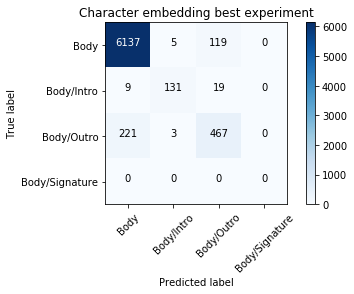

In [38]:
%matplotlib inline
#sorting and list manipulation functions
import operator
#Operating system functions for interacting with folders and files
import codecs
import errno
import os
import sys
import traceback
#Mathematical functions to handle vectors
import numpy as np
#Plotting functions for visualizing results
import matplotlib.pyplot as plt
import itertools

#Check if the notebook path is already loaded
try:  
    noteBookPath
except NameError:
    print ("NotebookPath variable dont exist, applying default one")
    noteBookPath= os.getcwd()
    pass

#Check if dataset path exist
datasetFolder="dataset"
try:
    datasetsPath=os.path.join(noteBookPath,datasetFolder) 
    if not os.path.isdir(datasetsPath): raise Exception("'Dataset' folder dont exist")
    else: 
        print ("Directory: '"+ datasetFolder+"' exists")
        pass
except SystemExit as e:
    print(e)

#Create experiments folder if not exists
dirName="experiments"
try:
    os.mkdir(os.path.join(noteBookPath,dirName) )
    print ("Directory: '"+dirName+"' Created") 
except OSError as e:
    if e.errno == errno.EEXIST:
        print ("Directory: '"+ dirName+"' exists")
        pass
    else:
        raise 
except:
    print ("Unexpected error")
    pass  

#Check if the experiments folder path exist
try:  
    experimentsPath
except NameError:
    print ("datasetPath variable dont exist, applying default one")
    experimentsPath=os.path.join(noteBookPath,dirName)
    pass

#Python Script
try:
    
    #Storage all results together in order to get the best ones
    totalResults=[]
    #Character ngram size
    characterNgram=1
    #Character embedding size vectors
    featureNumbers=[100,200,300,400,500,600]
    #Best results to display
    numResults=30
    #Labels used to predict the structure of emails
    structuralLabels=["Body", "Body/Intro", "Body/Outro", "Body/Signature"]
    
    #Iterate over each previously created result file
    for number in featureNumbers:
        
        document = "ResultsNgram-"+str(characterNgram)+"-EmbeddingSize-"+str(number)+".txt"  
        filePath = os.path.join(experimentsPath,document)
        
        if (os.path.isfile(filePath)):
            
            print("Get results of document: "+ document)
            
            with codecs.open(filePath,"r", "ISO-8859-1") as file:
                #Append each results (and its parameters) 
                documentResults=[((line.replace('\n','')).split(",")) for line in file]
            totalResults.extend(documentResults)
    
        else: print ("The following document dont exist: "+document)
            
    print("\nTotal number of experiments: "+str(len(totalResults))) 
    
    #Order the experimental results by Accuracy, TP and TN
    bestResults=sorted(totalResults, key=operator.itemgetter(5),reverse=True)
    
    print("\nCharacter embedding best experiments according to F1 values")
    #Print ordered results
    for values in bestResults[:numResults]:
        print(",".join(values))      
    
    bestResult=bestResults[0]  
    
    print("\nBest result Accuracy:"+str(bestResult[4]))
    print("Best result F1:"+str(bestResult[5]))
    print("Best confusion matrix")
    cm= (np.array([int(x) for x in bestResult[6:]])).reshape(4, 4)
    #Plot the best confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Character embedding best experiment')
    plt.colorbar()
    tick_marks = np.arange(len(structuralLabels))
    plt.xticks(tick_marks, structuralLabels, rotation=45)
    plt.yticks(tick_marks, structuralLabels)
    fmt = '.2f' if False else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

except IOError as e:
    print ("Could not read file")
    print(traceback.format_exc())
    print(e)
except Exception as e:
    print ("Unexpected error")
    print(traceback.format_exc())
    print(e) 

## Future/Alternative work

Future research avenues includes some of the following:


1\. Analyze other dataset options for improving the model creation of the friend/foe classifier.

2\. Use other test data samples for checking the overall performance of the classifier over distinct types of emails.

3\. Use different supervised learning algorithms to improve classification (see: https://scikit-learn.org/stable/supervised_learning.html).

4\. Use other Neural Network architectures and methods to improve results.

5\. Improve error handling in the implemented Python code.

6\. Considering that are millions of emails/texts in the project (very likely) (https://ased.io/) it is necessary to use parallel techniques to distribute the classification work (see: https://spark.apache.org/ or http://docs.dask.org/en/latest/why.html).